In [1]:
# Importação das blibliotecas principais
import pandas as pd
import numpy as np
import warnings

# Importação do modelo e suas dependencias
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer


# Importação das bibliotecas de plotagem
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots

In [2]:
warnings.filterwarnings("ignore")

In [3]:
# Importação do arquivo usado para modelagem
df = pd.read_feather('datasets/dados.feather')
df.head()

,A002,A003,A004,A005,UF,V1012,V1022,B0101,B0102,B0103,...,B009F,B011,B007,C013,C002,C004,D0053,D0051,mes_numero,mes_descricao
0,36,1,4,5,11,4,1,2,2,2,...,0.0,2,1,0.0,0.0,0.0,1200.0,1,9,setembro
1,30,2,4,7,11,4,1,2,2,2,...,0.0,2,2,0.0,0.0,0.0,1200.0,1,9,setembro
2,13,1,4,2,11,4,1,2,2,2,...,0.0,4,1,0.0,0.0,0.0,1200.0,1,9,setembro
3,11,1,4,2,11,4,1,2,2,2,...,0.0,4,1,0.0,0.0,0.0,1200.0,1,9,setembro
4,57,2,1,2,11,1,1,2,2,2,...,0.0,2,2,0.0,2.0,0.0,0.0,2,9,setembro


In [4]:
df_new = df.copy().drop(columns='mes_descricao')
df_new.head()

,A002,A003,A004,A005,UF,V1012,V1022,B0101,B0102,B0103,...,B009E,B009F,B011,B007,C013,C002,C004,D0053,D0051,mes_numero
0,36,1,4,5,11,4,1,2,2,2,...,0.0,0.0,2,1,0.0,0.0,0.0,1200.0,1,9
1,30,2,4,7,11,4,1,2,2,2,...,0.0,0.0,2,2,0.0,0.0,0.0,1200.0,1,9
2,13,1,4,2,11,4,1,2,2,2,...,0.0,0.0,4,1,0.0,0.0,0.0,1200.0,1,9
3,11,1,4,2,11,4,1,2,2,2,...,0.0,0.0,4,1,0.0,0.0,0.0,1200.0,1,9
4,57,2,1,2,11,1,1,2,2,2,...,0.0,0.0,2,2,0.0,2.0,0.0,0.0,2,9


In [5]:
# Cria um dataframe apenas com registros de amostras positivadas
selecao = df_new['B009B'].isin([1,3,4]) | df_new['B009D'].isin([1,3,4]) | df_new['B009F'].isin([1,3,4])
df_positivado = df_new[selecao]

In [6]:
# Verifica o tamanho do dataframe
df_new.shape

(1149197, 39)

In [7]:
# Plota um heatmap da correçãoa entre as variáveis das amostras positivadas
corr = df_new.drop(columns='B008').corr()
corr.style.background_gradient(cmap='coolwarm')

,A002,A003,A004,A005,UF,V1012,V1022,B0101,B0102,B0103,B0011,B0012,B0013,B0014,B0015,B0019,B005,B006,B0041,B0042,B0044,B0045,B0043,B0046,B009A,B009B,B009C,B009D,B009E,B009F,B011,B007,C013,C002,C004,D0053,D0051,mes_numero
A002,1.000000,0.048482,-0.079444,0.130180,0.075270,0.003774,-0.019772,-0.146071,-0.312380,0.005785,-0.003399,-0.008877,-0.004822,-0.008025,-0.013899,-0.012291,0.007918,0.016252,0.012400,0.012237,0.011995,0.011940,0.011890,0.011659,0.060568,0.033488,0.058630,0.042194,0.055815,0.045577,-0.057867,-0.050914,0.039244,0.349248,0.049441,-0.184004,0.207607,0.003910
A003,0.048482,1.000000,-0.013371,0.066038,0.001069,0.000169,-0.034067,-0.019790,-0.041660,-0.008456,-0.000715,-0.001522,-0.003630,-0.001513,-0.009525,-0.002741,0.008590,-0.000462,0.011825,0.013414,0.013367,0.013380,0.012950,0.013603,0.011672,0.010552,0.013158,0.005633,0.012409,0.006883,0.085277,-0.014539,-0.038255,0.183004,0.024181,-0.004117,0.009043,0.000675
A004,-0.079444,-0.013371,1.000000,-0.119791,-0.266116,0.001253,0.073349,0.016299,0.025245,0.018847,0.003489,0.003864,0.003704,0.004440,0.004262,0.005513,-0.002797,-0.001546,-0.005104,-0.003054,-0.001186,-0.001989,-0.003396,-0.000863,-0.010679,-0.034633,-0.023672,-0.004457,-0.019880,-0.010689,-0.003592,0.145641,-0.028868,0.030931,0.002127,0.133862,-0.172679,-0.000290
A005,0.130180,0.066038,-0.119791,1.000000,0.074401,0.000856,-0.225389,0.026796,0.042757,-0.002880,0.001924,0.002542,-0.001755,0.001608,-0.006304,-0.001032,0.018677,0.000115,0.021147,0.017153,0.015238,0.015906,0.017957,0.013856,0.157993,0.127758,0.173058,0.101148,0.165528,0.105476,-0.247241,-0.222515,0.189155,-0.016666,0.061244,-0.147925,0.185116,0.001280
UF,0.075270,0.001069,-0.266116,0.074401,1.000000,-0.003434,-0.096999,-0.020397,-0.032107,-0.023769,0.000705,-0.001419,-0.000246,-0.002078,-0.002247,-0.002437,0.008266,0.003874,0.012674,0.010127,0.009304,0.010266,0.011174,0.009461,0.003572,0.069904,0.037021,-0.006222,0.027851,0.007370,0.001808,-0.131018,0.013344,-0.050929,-0.008124,-0.157253,0.188540,0.000068
V1012,0.003774,0.000169,0.001253,0.000856,-0.003434,1.000000,-0.001212,0.001116,0.000398,0.003062,-0.005247,-0.004938,-0.005102,-0.005173,-0.004777,-0.004970,0.002675,-0.000483,0.002840,0.002847,0.002507,0.002583,0.002418,0.002410,0.008626,0.006584,0.010123,0.004490,0.008575,0.006245,-0.014740,-0.002609,-0.001742,-0.000300,-0.005617,-0.014505,-0.000789,-0.003796
V1022,-0.019772,-0.034067,0.073349,-0.225389,-0.096999,-0.001212,1.000000,0.006546,-0.001520,0.009544,-0.010789,-0.010635,-0.010500,-0.011027,-0.009701,-0.009653,-0.015721,-0.004245,-0.017157,-0.012939,-0.013397,-0.014007,-0.015326,-0.012977,-0.073153,-0.070518,-0.085204,-0.044831,-0.083298,-0.040785,0.044070,0.149118,-0.049787,0.011169,-0.032866,0.098390,-0.127359,-0.003053
B0101,-0.146071,-0.019790,0.016299,0.026796,-0.020397,0.001116,0.006546,1.000000,0.735455,0.736408,0.386504,0.381154,0.382233,0.391227,0.378659,0.387935,-0.004679,-0.008016,-0.009694,-0.009324,-0.009466,-0.009352,-0.009098,-0.009217,-0.016686,-0.011790,-0.015386,-0.012360,-0.013929,-0.014087,0.225030,0.401686,0.002527,-0.054585,-0.008380,0.025214,-0.026272,-0.010475
B0102,-0.312380,-0.041660,0.025245,0.042757,-0.032107,0.000398,-0.001520,0.735455,1.000000,0.641274,0.336055,0.333312,0.332934,0.340993,0.332527,0.339483,-0.007321,-0.011571,-0.014352,-0.015052,-0.015047,-0.015232,-0.014851,-0.015371,-0.022766,-0.013403,-0.020771,-0.017077,-0.018512,-0.020155,0.178556,0.353239,0.007997,-0.119937,-0.013982,0.054272,-0.057912,-0.010807
B0103,0.005785,-0.008456,0.018847,-0.002880,-0.023769,0.003062,0.009544,0.736408,0.641274,1.000000,0.395178,0.390707,0.392019,0.401538,0.388018,0.395947,-0.009224,-0.006642,-0.015627,-0.015323,-0.015284,-0.015765,-0.015367,-0.015486,-0.018980,-0.019725,-0.020442,-0.013391,-0.018200,-0.016296,0.245805,0.418020,-0.005875,0.017014,-0.004161,0.000808,-0.000296,-0.010500


In [8]:
# Plota um heatmap da correçãoa entre todas as variaveis
corr = df_positivado.drop(columns='B008').corr()
corr.style.background_gradient(cmap='coolwarm')

,A002,A003,A004,A005,UF,V1012,V1022,B0101,B0102,B0103,B0011,B0012,B0013,B0014,B0015,B0019,B005,B006,B0041,B0042,B0044,B0045,B0043,B0046,B009A,B009B,B009C,B009D,B009E,B009F,B011,B007,C013,C002,C004,D0053,D0051,mes_numero
A002,1.000000,0.016698,-0.042290,-0.047567,0.030785,0.003306,0.004263,-0.228634,-0.387129,-0.005048,0.008571,-0.012167,0.005959,-0.017073,-0.006143,-0.028699,0.003906,0.057258,0.010497,0.009237,0.007896,0.006324,0.006619,0.007233,-0.018540,0.020148,0.024124,-0.020270,-0.071237,0.069475,0.057713,-0.033348,0.006115,0.251646,0.027369,-0.093625,0.106946,-0.005964
A003,0.016698,1.000000,-0.006137,0.064115,0.000352,0.008614,-0.015036,-0.014847,-0.034037,-0.045692,0.006847,-0.001761,-0.011640,-0.007348,-0.022314,-0.009496,0.015460,-0.012934,0.013151,0.013536,0.016091,0.015295,0.013175,0.014909,0.014926,0.002761,-0.007465,0.003444,0.003082,0.001597,0.085940,0.010596,-0.033552,0.170399,0.012844,0.001535,-0.003733,-0.002559
A004,-0.042290,-0.006137,1.000000,-0.130328,-0.245740,0.000929,0.058152,0.010188,0.005176,0.035718,0.017774,0.018375,0.013794,0.010740,0.018175,0.022220,-0.034009,-0.006029,-0.044444,-0.043499,-0.035301,-0.038075,-0.043533,-0.032997,0.126610,-0.094296,-0.062513,0.046102,-0.017957,0.000593,-0.005898,0.182130,-0.029337,0.042615,0.003777,0.127496,-0.160922,-0.024998
A005,-0.047567,0.064115,-0.130328,1.000000,0.074607,0.008747,-0.211572,0.071583,0.124402,-0.027460,0.013202,0.006668,-0.001159,0.008293,-0.006403,-0.005350,0.020608,-0.018480,0.024638,0.015296,0.006008,0.008749,0.019656,0.001452,-0.147759,0.099752,0.063183,-0.032330,-0.019117,0.030175,-0.186064,-0.335159,0.170829,-0.228472,0.020116,-0.191639,0.236857,0.016126
UF,0.030785,0.000352,-0.245740,0.074607,1.000000,0.002824,-0.105625,0.001856,-0.012320,-0.014627,-0.032564,-0.033625,-0.026606,-0.018386,-0.033426,-0.031243,0.070404,0.016734,0.086429,0.079018,0.076755,0.081996,0.084730,0.076011,-0.275519,0.191668,0.168856,-0.125251,0.028940,0.001321,0.027153,-0.174989,0.023735,-0.062979,-0.002539,-0.146431,0.161710,0.032401
V1012,0.003306,0.008614,0.000929,0.008747,0.002824,1.000000,0.002149,0.006147,-0.000117,0.006052,-0.007316,-0.005712,-0.009204,-0.006551,-0.009138,-0.007221,0.014405,-0.005020,0.012432,0.008475,0.011514,0.012633,0.012063,0.009638,-0.010806,0.017612,0.024827,-0.013871,-0.011162,0.004768,0.000674,-0.013782,0.002483,0.022167,-0.007439,-0.020630,0.002501,0.007902
V1022,0.004263,-0.015036,0.058152,-0.211572,-0.105625,0.002149,1.000000,-0.000468,-0.009054,0.013955,-0.008607,-0.007887,-0.005821,-0.003706,-0.003370,0.000230,-0.018107,-0.003260,-0.021039,-0.012025,-0.012823,-0.014571,-0.021387,-0.010382,0.127262,-0.093545,-0.038720,0.021625,-0.034398,0.016997,0.040909,0.174983,-0.040818,0.065065,0.006491,0.090183,-0.104313,-0.009355
B0101,-0.228634,-0.014847,0.010188,0.071583,0.001856,0.006147,-0.000468,1.000000,0.496645,0.361544,-0.006806,0.016055,0.003802,0.018486,0.006278,0.018905,-0.005327,-0.028930,-0.005790,0.006204,0.005629,0.007645,0.007123,0.005972,-0.000730,-0.007131,0.001852,0.010467,0.032592,-0.025452,-0.052124,0.037081,0.022558,-0.107416,-0.005529,-0.002384,0.002015,0.003916
B0102,-0.387129,-0.034037,0.005176,0.124402,-0.012320,-0.000117,-0.009054,0.496645,1.000000,0.292156,-0.000106,0.023161,0.013136,0.023660,0.014310,0.027273,-0.008458,-0.043032,-0.018061,-0.008837,-0.009256,-0.009398,-0.005303,-0.009321,-0.003018,-0.015014,-0.008218,0.006051,0.039892,-0.035785,-0.081113,0.017589,0.031353,-0.168102,-0.018905,0.005050,-0.000439,0.003133
B0103,-0.005048,-0.045692,0.035718,-0.027460,-0.014627,0.006052,0.013955,0.361544,0.292156,1.000000,0.003181,0.021317,0.024390,0.037530,0.026514,0.028668,-0.004317,-0.019982,-0.011022,-0.001317,0.000866,-0.001268,-0.001431,0.000283,0.018177,-0.026402,-0.001765,-0.001626,0.012673,-0.016537,-0.010829,0.075043,0.009781,-0.028701,-0.015204,-0.002865,-0.005953,0.000583


In [9]:
def fMonstaFaixaEtaria(row):
    if(row <= 19):
        return 1
    elif((row >= 20) and (row <= 59)):
        return 2
    elif(row > 59):
        return 3

In [10]:
def fteveSintomas(s):
    if(s['B0011'] == 1) or (s['B0012'] == 1) or (s['B0013'] == 1) or (s['B0014'] == 1) or (s['B0015'] == 1) or (s['B0019'] == 1):
        return 1
    else:
        return 0

In [11]:
# quantidade de sintomas
def fQuantidadeSintomas(s):
    iQuantidade = 0

    if (s['B0011'] == 1):
        iQuantidade += 1

    if (s['B0012'] == 1):
        iQuantidade += 1

    if (s['B0013'] == 1):
        iQuantidade += 1

    if (s['B0014'] == 1):
        iQuantidade += 1

    if (s['B0015'] == 1):
        iQuantidade += 1

    if (s['B0019'] == 1):
        iQuantidade += 1

    return iQuantidade

In [12]:
# 1 = possui plano de saúde; 0 Não - possui
def fPossuiPlanoSaude(row):
    if(row == 1):
        return 1
    else:
        return 0

In [13]:
# 1 = fez home office; 0 Não - fez
def fHomeOffice(row):
    if(row == 1):
        return 1
    elif (row == 2):
        return 2
    else:
        return 0

In [14]:
# com base na documentação, serão considerados 3 valores 0, 1, 2, onde 0 não teve distanciamento, 1 teve parcial distanciamento e 3 fez total distanciamento
# 1,2,9 -> Não respeitou = 0
# 3,4 -> Respeitou = 1
def fDistanciamento(row):
    if(row == 1) or (row == 9) or (row == 2):
        return 0
    elif(row == 3) or (row == 4):
        return 1
        

In [15]:
def fFoiInternado(row):
   if(row == 1):
      return 1
   else:
      return 0

In [16]:
# 0 = negativou; 1 = positivou

positivou = [1,3,4]

def fPositivou(s):
    if(s['B009B'] in positivou) or (s['B009D'] in positivou) or (s['B009F'] in positivou):
        return 1
    else:
        return 0

In [17]:
# Teve sintoma
def fTeveSintoma(row):
    if (row == 1):
        return 1
    else: 
        return 0

In [18]:
df.columns

Index(['A002', 'A003', 'A004', 'A005', 'UF', 'V1012', 'V1022', 'B0101',
       'B0102', 'B0103', 'B0011', 'B0012', 'B0013', 'B0014', 'B0015', 'B0019',
       'B005', 'B006', 'B0041', 'B0042', 'B0044', 'B0045', 'B0043', 'B0046',
       'B008', 'B009A', 'B009B', 'B009C', 'B009D', 'B009E', 'B009F', 'B011',
       'B007', 'C013', 'C002', 'C004', 'D0053', 'D0051', 'mes_numero',
       'mes_descricao'],
      dtype='object')

In [19]:
# criação de um dataframe contendo a faixa etária, se teve sintomas, se possui plano de saúde, se esteve em home office, sse fez distanciamento, se foi internado
# Para faixa etária serão usados os grupos categorizados pelo IBGE, sedo eles: Jovens -> até 19anos, Adultos -> de 20 até 59 anos e Idosos de 60+
# Para todas as colunas serão atribuidos valores numericos de 0 a 9
# Para as solunas de sintomas, 0 representa que não foi apresentado nenhum sintoma e 1 teve sintoma
labels = ['faixa_etaria','teve_sintomas','possui_plano_saude','home_office','distanciamento','foi_internado']
cols = ['A002',    
        'B0011',	
        'B0012',
        'B0013',
        'B0014',
        'B0015',
        'B0019',
        'B007',
        'C013',
        'B011',
        'B005']

df_sintomas = df[['B0011', 'B0012','B0013','B0014','B0015','B0019']] 

df_exames = df[['B009B','B009D','B009F']]


df_cluster = pd.DataFrame()

df_cluster['faixa_etaria'] = df['A002']
df_cluster['faixa_etaria'] = df_cluster['faixa_etaria'].apply(fMonstaFaixaEtaria)
df_cluster['teve_sintomas'] = df_sintomas.apply(fteveSintomas, axis=1)

df_cluster['qtd_sintomas'] = df_sintomas.apply(fQuantidadeSintomas, axis=1)

df_cluster['teve_febre'] = df['B0011'].apply(fTeveSintoma)
df_cluster['teve_tosse'] = df['B0012'].apply(fTeveSintoma)
df_cluster['teve_dor_garganta'] = df['B0013'].apply(fTeveSintoma)
df_cluster['teve_dificuldade_respirar'] = df['B0014'].apply(fTeveSintoma)
df_cluster['teve_dor_cabeca'] = df['B0015'].apply(fTeveSintoma)
df_cluster['teve_dor_fadiga'] = df['B0019'].apply(fTeveSintoma)

df_cluster['possui_plano_saude'] = df['B007'].apply(fPossuiPlanoSaude)
df_cluster['home_office'] = df['C013'].apply(fHomeOffice)
df_cluster['distanciamento'] = df['B011'].apply(fDistanciamento)
df_cluster['foi_internado'] = df['B005'].apply(fFoiInternado)
df_cluster['positivou'] = df_exames.apply(fPositivou, axis=1)
df_cluster.head(20)


,faixa_etaria,teve_sintomas,qtd_sintomas,teve_febre,teve_tosse,teve_dor_garganta,teve_dificuldade_respirar,teve_dor_cabeca,teve_dor_fadiga,possui_plano_saude,home_office,distanciamento,foi_internado,positivou
0,2,0,0,0,0,0,0,0,0,1,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,0,1,0,0
3,1,0,0,0,0,0,0,0,0,1,0,1,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0
5,2,0,0,0,0,0,0,0,0,0,0,1,0,0
6,2,0,0,0,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,0,0,0,0,0,0,0,1,0,0
8,1,0,0,0,0,0,0,0,0,0,0,1,0,0
9,1,0,0,0,0,0,0,0,0,0,0,1,0,0


In [20]:
df_cluster['home_office'].value_counts()

home_office
0    1100419
1      34021
2      14757
Name: count, dtype: int64

In [21]:
df_cluster['teve_tosse'].value_counts()

teve_tosse
0    1133824
1      15373
Name: count, dtype: int64

In [22]:
# seleciona apenas os casos positivos
selecao = df_cluster['positivou'] == 1
df_cluster = df_cluster[selecao]
df_cluster

,faixa_etaria,teve_sintomas,qtd_sintomas,teve_febre,teve_tosse,teve_dor_garganta,teve_dificuldade_respirar,teve_dor_cabeca,teve_dor_fadiga,possui_plano_saude,home_office,distanciamento,foi_internado,positivou
23,2,0,0,0,0,0,0,0,0,0,0,0,0,1
30,2,0,0,0,0,0,0,0,0,0,0,1,0,1
31,2,0,0,0,0,0,0,0,0,0,0,0,0,1
51,2,0,0,0,0,0,0,0,0,1,0,0,0,1
52,2,0,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1149129,2,0,0,0,0,0,0,0,0,1,0,0,0,1
1149130,2,0,0,0,0,0,0,0,0,1,0,0,0,1
1149131,1,0,0,0,0,0,0,0,0,1,0,1,0,1
1149132,1,0,0,0,0,0,0,0,0,1,0,1,0,1


In [23]:
# cria df com dados escalados
scaler = StandardScaler()
scaler.fit(df_cluster)
dados_escalonados = scaler.transform(df_cluster)


In [24]:
dados_escalonados_labels = df_cluster.columns

In [25]:
# elbow_m = KElbowVisualizer(KMeans(), k=10)
# elbow_m.fit(df_cluster)
# elbow_m.show()

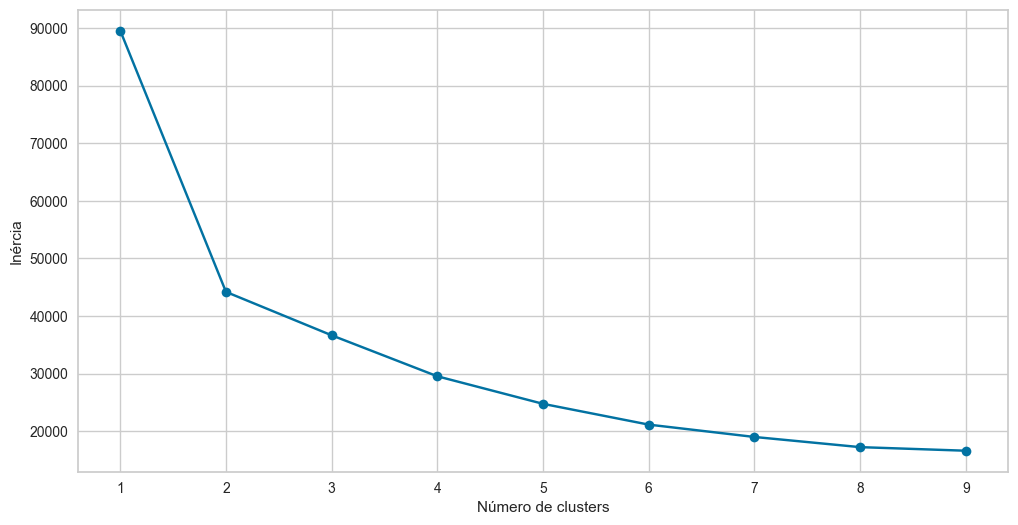

In [26]:
# Cria um grafico de elbow para encontrar a melhor quantidade de clusters
sse = []
k = list(range(1, 10))
for i in k:
    kmeans_elbow = KMeans(n_clusters=i, random_state=0)
    kmeans_elbow.fit(df_cluster)
    sse.append(kmeans_elbow.inertia_)

plt.rcParams['figure.figsize'] = (12, 6)
plt.plot(k, sse, '-o')
plt.xlabel(r'Número de clusters')
plt.ylabel('Inércia')
plt.show()

In [27]:
# cria o modelo com base no driagrama de elbow
kmeans = KMeans(n_clusters=2 ,random_state=0)
kmeans.fit(df_cluster)
centroides = kmeans.cluster_centers_
kmeans_labels = kmeans.predict(df_cluster)

In [28]:
dados_Escalonados = pd.DataFrame(df_cluster, columns=dados_escalonados_labels)

In [29]:
dados_Escalonados.head()

,faixa_etaria,teve_sintomas,qtd_sintomas,teve_febre,teve_tosse,teve_dor_garganta,teve_dificuldade_respirar,teve_dor_cabeca,teve_dor_fadiga,possui_plano_saude,home_office,distanciamento,foi_internado,positivou
23,2,0,0,0,0,0,0,0,0,0,0,0,0,1
30,2,0,0,0,0,0,0,0,0,0,0,1,0,1
31,2,0,0,0,0,0,0,0,0,0,0,0,0,1
51,2,0,0,0,0,0,0,0,0,1,0,0,0,1
52,2,0,0,0,0,0,0,0,0,1,0,0,0,1


In [30]:
# adiciona os clusters ao df
dados_Escalonados['Grupos'] = kmeans_labels

In [31]:
# cria um df com os dados reduzidos para apresentação no grafico de dispersão
reduced_data = PCA(n_components=2).fit_transform(dados_Escalonados)
result = pd.DataFrame(reduced_data, columns=['PCA1','PCA2'])

In [32]:
result

,PCA1,PCA2
0,-0.441967,0.175862
1,-0.357430,-0.204641
2,-0.441967,0.175862
3,-0.439882,0.202526
4,-0.439882,0.202526
...,...,...
35423,-0.439882,0.202526
35424,-0.439882,0.202526
35425,-0.362728,0.745108
35426,-0.362728,0.745108


Text(0, 0.5, 'PCA2')

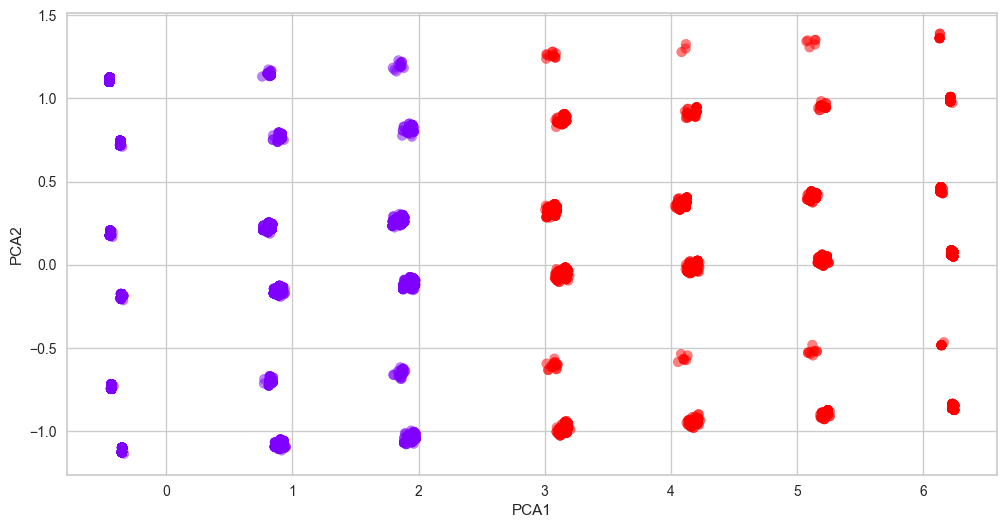

In [33]:
# plotando os dados identificando com os seus clusters
# plt.scatter(result['PCA2'],result['PCA1'], c=kmeans_labels, alpha=0.5, cmap='rainbow')
ax =  plt.scatter(x='PCA1', y='PCA2', data=result, c=kmeans_labels, alpha=0.5, cmap='rainbow')
plt.xlabel('PCA1')
plt.ylabel('PCA2')

In [34]:
# cria um df com os dados agrupados
df_grouped_faixa_etaria = dados_Escalonados.groupby('Grupos')['faixa_etaria'].value_counts()
df_grouped_plano_saude = dados_Escalonados.groupby('Grupos')['possui_plano_saude'].value_counts()
df_grouped_home_office = dados_Escalonados.groupby('Grupos')['home_office'].value_counts()
df_grouped_distanciamento = dados_Escalonados.groupby('Grupos')['distanciamento'].value_counts()
df_grouped_sintomas = dados_Escalonados.groupby('Grupos')[['teve_febre', 'teve_tosse','teve_dor_garganta','teve_dificuldade_respirar','teve_dor_cabeca','teve_dor_fadiga']].value_counts()



In [35]:
# cria um df com os dados agrupados
faixa_etaria = df_grouped_faixa_etaria.reset_index()
plano_saude = df_grouped_plano_saude.reset_index()
homme_office = df_grouped_home_office.reset_index()
distanciamento = df_grouped_distanciamento.reset_index()
teve_sintomas = df_grouped_sintomas.reset_index()


In [36]:
# com base na documentação, serão considerados 3 valores 0, 1, 2, onde 0 não teve distanciamento, 1 teve parcial distanciamento e 3 fez total distanciamento
sintomas = ['teve_febre', 'teve_tosse','teve_dor_garganta','teve_dificuldade_respirar','teve_dor_cabeca','teve_dor_fadiga']


faixa_etaria['faixa_etaria'].replace({1:'Jovem', 2:'Adulto',3:'Idoso'}, inplace=True)
plano_saude['possui_plano_saude'].replace({0:'Não', 1:'Sim'}, inplace=True)
homme_office['home_office'].replace({0:'Não se Aplica', 1:'Sim', 2:'Não'}, inplace=True)
distanciamento['distanciamento'].replace({0:'Não fez Distanciamento', 1:'Fez Distanciamento'}, inplace=True)

for sintoma in sintomas:
    teve_sintomas[sintoma].replace({0:'Não', 1:'Sim'}, inplace=True)


In [37]:
# cria um df com os dados agrupados pivotando o dataframe
df_faixa = faixa_etaria.pivot_table('count',['Grupos'],'faixa_etaria')
df_home_office = homme_office.pivot_table('count',['Grupos'],'home_office')
df_plano_saude = plano_saude.pivot_table('count',['Grupos'],'possui_plano_saude')
df_distanciamento = distanciamento.pivot_table('count',['Grupos'],'distanciamento')
df_teve_sintomas = teve_sintomas.pivot_table('count',['Grupos'],['teve_febre', 'teve_tosse','teve_dor_garganta','teve_dificuldade_respirar','teve_dor_cabeca','teve_dor_fadiga'])

In [38]:
# função para plotar os gráficos
def fPlotaGraficos(df, titulo):
    fig = px.bar(df,
                barmode='group', 
                labels={
                    'value':'Quantidade',
                    'index':'Grupos'
                },
                title=titulo,
                text_auto=True
    )
    fig.update_layout(
        autosize=False,
        height=700,
        title_x=0.5,
        xaxis = dict(
            tickmode='linear',
            dtick=1

        )
    )
    # fig.update_traces(
    #     marker_color='green'
    # )
    fig.show()    

Apresentação de gráficos para demonstrar a divisão demográfica por grupo

In [39]:
fPlotaGraficos(df_faixa, 'Distribuição de Faixa Etária por Grupo')

In [40]:
fPlotaGraficos(df_plano_saude, 'Distribuição de Possuidores de Plano de Saúde por Grupo')

In [41]:
fPlotaGraficos(df_home_office.drop(columns='Não se Aplica'), 'Distribuição de Aderentes de Home Office por Grupo')

In [42]:
fPlotaGraficos(df_distanciamento, 'Distribuição de Aderentes do Distanciamento por Grupo')

In [43]:
# função para criar um dataframe com os sintomas
def fCriaDataFrameSintomas(pTeve_Sintoma):
    df_grouped = dados_Escalonados.groupby('Grupos')[pTeve_Sintoma].value_counts()
    teve_sintoma = df_grouped.reset_index()
    teve_sintoma[pTeve_Sintoma].replace({0:'Não', 1:'Sim'}, inplace=True)
    return teve_sintoma.pivot_table('count',['Grupos'],pTeve_Sintoma)

In [44]:
df_teve_febre = fCriaDataFrameSintomas('teve_febre')
df_teve_tosse = fCriaDataFrameSintomas('teve_tosse')
df_teve_dor_garganta = fCriaDataFrameSintomas('teve_dor_garganta')
df_teve_dificuldade_respirar = fCriaDataFrameSintomas('teve_dificuldade_respirar')
df_teve_dor_cabeca = fCriaDataFrameSintomas('teve_dor_cabeca')
df_teve_dor_fadiga = fCriaDataFrameSintomas('teve_dor_fadiga')

In [45]:
df_teve_febre

teve_febre,Não,Sim
Grupos,,
0,32749.0,488.0
1,531.0,1660.0


Desse momento em diante, iniciam-se a plotagem dos graficos com base nos grupos e sintomas por grupo

In [46]:
fPlotaGraficos(df_teve_febre, 'Teve o Sintoma de Febre')

In [47]:
fPlotaGraficos(df_teve_tosse, 'Teve o Sintoma de Tosse')

In [48]:
fPlotaGraficos(df_teve_dor_garganta, 'Teve o Sintoma de Dor de Garganta')

In [49]:
fPlotaGraficos(df_teve_dificuldade_respirar, 'Teve o Sintoma de Dificuldade de Respirar')

In [50]:
fPlotaGraficos(df_teve_dor_cabeca, 'Teve o Sintoma de Dor de Cabeça')

In [51]:
fPlotaGraficos(df_teve_dor_fadiga, 'Teve o Sintoma de Fatiga')

In [52]:
contagen_sintomas = dados_Escalonados[['teve_febre', 'teve_tosse','teve_dor_garganta','teve_dificuldade_respirar','teve_dor_cabeca','teve_dor_fadiga']]

In [53]:
contagen_sintomas.value_counts()

teve_febre  teve_tosse  teve_dor_garganta  teve_dificuldade_respirar  teve_dor_cabeca  teve_dor_fadiga
0           0           0                  0                          0                0                  31091
1           1           1                  1                          1                1                    494
0           0           0                  0                          1                0                    440
            1           0                  0                          0                0                    218
1           1           1                  0                          1                1                    200
                                                                                                          ...  
            0           0                  1                          1                0                     10
0           0           1                  1                          1                0                      8
1

In [54]:
df_ListaSintomas = dados_Escalonados[['teve_febre', 'teve_tosse','teve_dor_garganta','teve_dificuldade_respirar','teve_dor_cabeca','teve_dor_fadiga']]

In [55]:
df_ListaSintomas

,teve_febre,teve_tosse,teve_dor_garganta,teve_dificuldade_respirar,teve_dor_cabeca,teve_dor_fadiga
23,0,0,0,0,0,0
30,0,0,0,0,0,0
31,0,0,0,0,0,0
51,0,0,0,0,0,0
52,0,0,0,0,0,0
...,...,...,...,...,...,...
1149129,0,0,0,0,0,0
1149130,0,0,0,0,0,0
1149131,0,0,0,0,0,0
1149132,0,0,0,0,0,0


In [56]:
contagen_sintomas['teve_tosse'].loc[lambda x:x==1].value_counts().values[0]

2369

In [57]:
vListaSintomas = ['teve_febre', 'teve_tosse','teve_dor_garganta','teve_dificuldade_respirar','teve_dor_cabeca','teve_dor_fadiga']
dSintomas = {}
vValores = []
for sintomas in vListaSintomas:
    dSintomas.update({sintomas:[df_ListaSintomas[sintomas].loc[lambda x:x==1].value_counts().values[0]]})

dSintomas

{'teve_febre': [2148],
 'teve_tosse': [2369],
 'teve_dor_garganta': [2029],
 'teve_dificuldade_respirar': [1294],
 'teve_dor_cabeca': [2742],
 'teve_dor_fadiga': [1985]}

In [58]:
df_total_sintomas = pd.DataFrame(dSintomas)

In [59]:
df_total_sintomas.T

,0
teve_febre,2148
teve_tosse,2369
teve_dor_garganta,2029
teve_dificuldade_respirar,1294
teve_dor_cabeca,2742
teve_dor_fadiga,1985


In [60]:
# cria o grafico para verificar qual foi o sintoma mais comum entre os positivados
fig = px.bar(df_total_sintomas.T,
            labels={
                'value':'Quantidade',
                'index':'Sintomas'
            },
            title='Total de Sintomas das Amostras Positivadas',
            text_auto=True
)
fig.update_layout(
    autosize=False,
    height=700,
    title_x=0.5,
    showlegend=False,
    xaxis = dict(
        tickmode='linear',
        dtick=1

    )
)
# fig.update_traces(
#     marker_color='green'
# )
fig.show() 